# CI Simulation (Supplementary Material)

- This notebook supplements the [confidence-intervals-for-ml.ipynb](confidence-intervals-for-ml.ipynb) with a case study.

- Here, we are interested in seeing whether the true model accuracy (generalization accuracy) is actually contained in the confidence intervals.

- For this, we create a synthetic dataset consiting of 10 million and 2 thousand data points for classification as shown in the next section.

## Large Synthetic Training and Test Sets

In [1]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=10_002_000,
    n_features=5,
    n_redundant=2,
    n_classes=2,
    n_clusters_per_class=1,
    random_state=123,
    flip_y=0.25,
)

In [2]:
X_train = X[:1_000]
y_train = y[:1_000]

X_test = X[1_000:2_000]
y_test = y[1_000:2_000]

X_huge_test = X[2_000:]
y_huge_test = y[2_000:]

- Note that the 1000 data points are used for training, the second 1000 data points are used for testing, and the remaining 10,000,000 data points represent the dataset we use to calculate the true performance of the model.

## True Generalization Performance

In [3]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=123, max_depth=3)
clf.fit(X_train, y_train)

acc_test_true = clf.score(X_huge_test, y_huge_test)
acc_test_true

0.8472259

## 1) Normal Approximation Interval Based on the Test Set

In [4]:
import numpy as np
import scipy.stats

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)


clf.fit(X_train, y_train)

acc_test = clf.score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(ci_lower, ci_upper)

0.8289298133898874 0.8730701866101126


In [5]:
results = {
    "Method 1: Normal approximation": {
        "Test accuracy": acc_test,
        "Lower 95% CI": ci_lower,
        "Upper 95% CI": ci_upper,
    }
}

### 2) Out-of-Bag (OOB) Bootstrap; Bootstrapping Training Sets -- Setup Step

In [6]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_valid_X, boot_valid_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)


confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=bootstrap_rounds - 1)


se = 0.0
for acc in bootstrap_train_accuracies:
    se += (acc - bootstrap_train_mean) ** 2
se = np.sqrt((1.0 / (bootstrap_rounds - 1)) * se)

ci_length = t_value * se

ci_lower_21 = bootstrap_train_mean - ci_length
ci_upper_21 = bootstrap_train_mean + ci_length

In [7]:
results["Method 2.1: Bootstrap, 1-sample CI"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower_21,
    "Upper 95% CI": ci_upper_21,
}

### 2.2) Bootstrap Percentile Method

In [8]:
ci_lower_22 = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper_22 = np.percentile(bootstrap_train_accuracies, 97.5)

In [9]:
results["Method 2.2: Bootstrap, percentile"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower_22,
    "Upper 95% CI": ci_upper_22,
}

### 2.3) .632 Bootstrap

In [10]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632

for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    train_acc = clf.score(X_train, y_train)
    valid_acc = clf.score(boot_valid_X, boot_valid_y)
    acc = weight * train_acc + (1.0 - weight) * valid_acc

    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)

In [11]:
ci_lower_23 = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper_23 = np.percentile(bootstrap_train_accuracies, 97.5)


results["Method 2.3: Bootstrap, .632"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower_23,
    "Upper 95% CI": ci_upper_23,
}

### 2.4) .632+ Bootstrap

- Unfortunately, this method is too computationally expensive for this dataset on a regular computer, which is why we skip it.

In [12]:
"""
from itertools import product
from sklearn.base import clone
from sklearn.metrics import accuracy_score


def no_information_rate(targets, predictions, loss_fn):
    combinations = np.array(list(product(targets, predictions)))
    return loss_fn(combinations[:, 0], combinations[:, 1])

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632


cloned_clf = clone(clf)
for i in range(bootstrap_rounds):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]
    
    cloned_clf.fit(boot_train_X, boot_train_y) 
    train_acc = clf.score(X_train, y_train)
    valid_acc = cloned_clf.score(boot_valid_X, boot_valid_y)
    
    gamma = (no_information_rate(
        y, cloned_clf.predict(X),
        accuracy_score))
    R = (valid_acc - train_acc) / (
        gamma - train_acc)

    weight = 0.632 / (1 - 0.368*R)
    
    
    acc = (weight*train_acc + (1. - weight)*valid_acc)
    
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)

"""

'\nfrom itertools import product\nfrom sklearn.base import clone\nfrom sklearn.metrics import accuracy_score\n\n\ndef no_information_rate(targets, predictions, loss_fn):\n    combinations = np.array(list(product(targets, predictions)))\n    return loss_fn(combinations[:, 0], combinations[:, 1])\n\nrng = np.random.RandomState(seed=12345)\nidx = np.arange(y_train.shape[0])\n\nbootstrap_train_accuracies = []\nbootstrap_rounds = 200\nweight = 0.632\n\n\ncloned_clf = clone(clf)\nfor i in range(bootstrap_rounds):\n    \n    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)\n    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)\n    \n    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]\n    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]\n    \n    cloned_clf.fit(boot_train_X, boot_train_y) \n    train_acc = clf.score(X_train, y_train)\n    valid_acc = cloned_clf.score(boot_valid_X, boot_valid_y)\n    \n    gamma = (no_information

In [13]:
"""
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)


results['Bootstrap, .632'] = \
           {'Test accuracy': bootstrap_train_mean,
            'Lower 95% CI': ci_lower,
            'Upper 95% CI': ci_upper}

"""

"\nci_lower = np.percentile(bootstrap_train_accuracies, 2.5)\nci_upper = np.percentile(bootstrap_train_accuracies, 97.5)\n\n\nresults['Bootstrap, .632'] =            {'Test accuracy': bootstrap_train_mean,\n            'Lower 95% CI': ci_lower,\n            'Upper 95% CI': ci_upper}\n\n"

### 3) Bootstrapping the Test Set predictions

In [14]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):

    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)

In [15]:
ci_lower_3 = np.percentile(test_accuracies, 2.5)
ci_upper_3 = np.percentile(test_accuracies, 97.5)

results["Method 3: Bootstrap test set"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower_3,
    "Upper 95% CI": ci_upper_3,
}

## Comparison

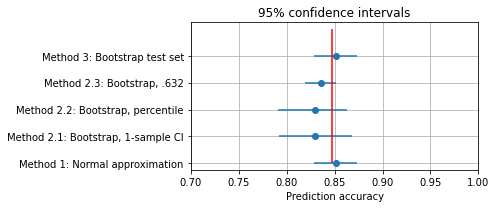

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = list(results.keys())

means = np.array([results[k]["Test accuracy"] for k in labels])
lower_error = np.array([results[k]["Lower 95% CI"] for k in labels])
upper_error = np.array([results[k]["Upper 95% CI"] for k in labels])

asymmetric_error = [means - lower_error, upper_error - means]


fig, ax = plt.subplots(figsize=(7, 3))
ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.7, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

ax.vlines(acc_test_true, [0], 5, lw=1.5, color="red", linestyle="-", label="True value")

plt.grid()
plt.tight_layout()
plt.savefig("matplotlib-figures/comparison-simulation.pdf")
plt.show()

- As it turns out all methods' 95% confidence intervals contain the true test accuracy, which is great. However, I noticed that changing the parameters of the data generating function slightly will have a huge effect on this outcome, so take it with a grain of salt.

- Ok, ideally we also want to repeat this simulation many times and see if the confidence intervals really contain the true parameter 95% of the time. I originally wanted to leave this as an exercise to the reader, but then I couldn't resist 😛; see [ci-simulation-repeated.ipynb](ci-simulation-repeated.ipynb).